In [15]:
from numpy import loadtxt, pi
path = loadtxt(r"C:\Users\Srinivas\Documents\GitHub\New_world\robot_trajectory3.txt")
poses = []
for i in range(len(path)):
    if path[i][3]!=0:
        if path[i][3] == 1:
            poses.append([path[i][0],path[i][1],path[i-1][2],pi])
        elif path[i][3] == 3:
            poses.append([path[i][0],path[i][1],path[i-1][2],0])
        elif path[i][3] == 2:
            poses.append([path[i][0],path[i][1],path[i-1][2],3*pi/2])
        elif path[i][3] == 4:
            poses.append([path[i][0],path[i][1],path[i-1][2],pi/2])
lposes = len(poses)

In [16]:
from __future__ import division
from math import tan, atan, sqrt, cos, sin, fabs
from numpy import eye, diag, array, exp, ceil, floor, dot, arange
from numpy.linalg import inv, det
from random import gauss, randint, uniform
import copy
import sys
from time import time
class Particle:
    def __init__(self,pose):
        self.pose = pose
        self.landmark_poses = []
        self.landmark_covariances = []
        self.wall_list = [] # Stores the histogram as a list from the tree w
        self.var = 0
        self.length = 480
        self.block = 5
        self.width = 30
        self.w = [] # Histogram references for the landmark features in a tree data structure
    
    def number_of_landmarks(self):
        return len(self.w)
    
    @staticmethod
    def motion(pose, control, WB, dt):  
        angle = (control[1]+pose[2])%(2*pi)
        return ([x+y for x,y in zip(pose,[control[0]*dt*cos(angle),
                                          control[0]*dt*sin(angle),
                                          control[0]*dt*sin(control[1])/WB])])
    
    def move(self,control,WB,dt,pose):
        # Pruning the histogram based on the previous pose and current pose here;
        self.hist_prune(self.pose,pose)
        self.pose = pose
        
    def expected_measurement(self,landmark):   # Not considering the other component  
        return array([landmark[0],tan(landmark[1]-self.pose[2])])      
    
    def measurement_correspondence(self,pose,measurement,number_of_landmarks,Qt_measurement_covariance):
        likelihoods = []
        for i in range(number_of_landmarks):
            likelihoods.append(self.landmark_correspondence(measurement,i,Qt_measurement_covariance))
        return likelihoods
    
    @staticmethod
    def dh_dlandmark(pose,landmark):
        return array([[1,0],[0,-1/(cos(pose[2]-landmark[1])**2)]]) # H - Direct odometry measurement and collision
    
    def H_and_Ql_from_measurement(self,landmark,Qt_measurement_covariance,i):
        
        H = self.dh_dlandmark(self.pose,landmark)
        Ql = dot(dot(H,self.landmark_covariances[i]),H.T) + Qt_measurement_covariance
        
        return (H, Ql)
        
    def landmark_correspondence_likelihood(self,measurement,landmark_number,Qt):
        # For a given measurment and a landmark number, it returns a suitable likelihood value of the correspondence           
        landmark = self.w[landmark_number]
        num_wall = len(landmark)
        likelihood=[]
        # For clubbing features of a landmark
        estimate_angle = (self.pose[2]+atan(measurement[2]))%(2*pi)
        epsilon = 10
        count = 0
        for i in arange(1,num_wall,1):
            phi = landmark[i][1]
            theta = self.pose[2]
            # Prune the landmark which are not in the robot's frame of collision
            if phi == (pi/2 * floor(theta/(pi/2)))%(2*pi) or phi == (pi/2 * ceil(theta/(pi/2)))%(2*pi):
                if landmark[i][1] % pi == 0:
                    zhat = self.expected_measurement(landmark[i])
                    H, Ql = self.H_and_Ql_from_measurement(landmark[i],diag([Qt[0][0],Qt[2][2]]),landmark_number)
                    dz = array([measurement[0],measurement[2]])-zhat
                else:
                    zhat = self.expected_measurement(landmark[i])
                    H, Ql = self.H_and_Ql_from_measurement(landmark[i],diag([Qt[1][1],Qt[2][2]]),landmark_number)
                    dz = array([measurement[1],measurement[2]])-zhat
                
                # Compute likelihood
                sqrtdetQl = sqrt(det(Ql))
                normal = 1 / (2*pi*sqrtdetQl)
                l = normal * exp(-0.5*dot(dot(dz.T,inv(Ql)),dz))
                count = 1
                
            # Similar features of landmarks are taken into account, that is two close features with 0 & 180 deg, and 90 & 270deg 
            elif count != 1 and (estimate_angle - phi) % pi == 0 and fabs(measurement[int(floor(phi % pi))]-landmark[i][0])<self.width + epsilon and i == (num_wall - 1):
                if landmark[i][1] % pi == 0:
                    angle = (self.pose[2]+atan(measurement[2])) % (2*pi)
                    self.w[landmark_number].insert(len(self.w[landmark_number]),array([measurement[0],angle]))
                    mod_landmark = array([landmark[i][0] + (self.width)*cos(landmark[i][1]), (landmark[i][1]+pi)%(2*pi)])
                    H, Ql = self.H_and_Ql_from_measurement(mod_landmark,diag([Qt[0][0],Qt[2][2]]),landmark_number)
                    dz = array([measurement[0],measurement[2]])-self.expected_measurement(mod_landmark)
                else:
                    angle = (self.pose[2]+atan(measurement[2])) % (2*pi)
                    self.w[landmark_number].insert(len(self.w[landmark_number]),array([measurement[1],angle]))
                    mod_landmark = array([landmark[i][0] + (self.width)*sin(landmark[i][1]), (landmark[i][1]+pi)%(2*pi)])
                    H, Ql = self.H_and_Ql_from_measurement(mod_landmark,diag([Qt[1][1],Qt[2][2]]),landmark_number)
                    dz = array([measurement[1],measurement[2]])-self.expected_measurement(mod_landmark)
                
                # Compute likelihood
                sqrtdetQl = sqrt(det(Ql))
                normal = 1 / (2*pi*sqrtdetQl)
                l = normal * exp(-0.5*dot(dot(dz.T,inv(Ql)),dz))
            
            else:
                l = 0
            likelihood.append(l)
        return max(likelihood)
    
    def dis_Bayes(self,wall_num, index, index_stddev): # The landmark, the position of measurement of 
        index = int(round(index/self.block,0))
        for i in range(index_stddev):
            b=1.5-i*(0.5/index_stddev) 
            if index - i >= 0: 
                self.wall_list[wall_num][index-i]*=b
            if index + i <=int(self.length/self.block)-1:
                self.wall_list[wall_num][index+i]*=b

        self.wall_list[wall_num] = [i*50/sum(self.wall_list[wall_num]) for i in self.wall_list[wall_num]] # Scale=5
            
    def initialize_new_landmark(self,measurement,Qt, l):
        self.w.insert(self.var,[self.var])
        orientation = (self.pose[2]+atan(measurement[2])) % (2*pi)
        
        if orientation % pi == 0: # Need to encode x and theta component in Sigma
            self.w[self.var].append([measurement[0], orientation])
            self.wall_list.append([1/l]*l)
            self.dis_Bayes(self.var,int(measurement[1]),20)
            
            Hinv = array([[1,0],[0,1/(1+measurement[2]**2)]])
            Qtx = diag([Qt[0][0],Qt[2][2]])
            Sigma = dot(dot(Hinv,Qtx),Hinv.T)
            self.landmark_covariances.append(Sigma)
        else:
            self.w[self.var].append([measurement[1], orientation])
            self.wall_list.append([1/l]*l)
            self.dis_Bayes(self.var,int(measurement[0]),20)   
            
            Hinv = array([[1,0],[0,1/(1+measurement[2]**2)]])
            Qty = diag([Qt[1][1],Qt[2][2]]) # y component and orientation
            Sigma = dot(dot(Hinv,Qty),Hinv.T)
            self.landmark_covariances.append(Sigma)
            
        self.var = self.var + 1

    def update_landmark(self,measurement,landmark_number,Qt):
        threshold = 10
        up_element= 100
        
        # Update the corresponding landmark with the histogram update as well
        for i in arange(1,len(self.w[landmark_number]),1):
            mu = self.w[landmark_number][i]
            if (fabs(mu[0] - self.pose[0]) < threshold and mu[1] % pi == 0) or (fabs(mu[0] - self.pose[1]) < threshold and mu[1] % (pi/2) == 0):
                up_element = i # Corresopnding landmark to be updated
                angle = mu[1]
                t = floor(angle % pi)
                Sigma = self.landmark_covariances[landmark_number]
                H, Ql = self.H_and_Ql_from_measurement(mu,diag([Qt[t][t],Qt[2][2]]),landmark_number)
                K = dot(dot(Sigma,H.T),inv(Ql))
                # Histogram update
                if angle % pi == 0:
                    measure = array([measurement[0],measurement[2]])
                    self.w[landmark_number][i] = mu + dot(K,(measure - self.expected_measurement(mu)))
                    self.landmark_covariances[landmark_number] = dot((eye(2) - K*H),Sigma)
                    self.dis_Bayes(landmark_number,int(measurement[1]),20)
                else:
                    measure = array([measurement[1],measurement[2]])
                    self.w[landmark_number][i] = mu + dot(K,(measure - self.expected_measurement(mu)))
                    self.landmark_covariances[landmark_number] = dot((eye(2) - K*H),Sigma)
                    self.dis_Bayes(landmark_number,int(measurement[0]),20)
        
        # Update the other features within the same landmark due to correlation from wall width and orientation
        if up_element != 100: # Execute this for loop only when the if condition in the above for loop gets executed
            for i in arange(1,len(self.w[landmark_number]),1):
                if up_element !=i:
                    mu = self.w[landmark_number][i]
                    if angle - mu[1] > 0:
                        self.w[landmark_number][i][0] = self.w[landmark_number][up_element][0] - self.width
                    else:
                        self.w[landmark_number][i][0] = self.w[landmark_number][up_element][0] + self.width
        # Need to update other ladnarks as a result of correlation as well
    
    def update_particle(self,measurement,number_of_landmarks,minimum_correspondence_likelihood,Qt_measurement_covariance):
        likelihoods = []
        for i in range(number_of_landmarks):
            likelihoods.append(self.landmark_correspondence_likelihood(measurement,i,Qt_measurement_covariance))
        if not likelihoods or max(likelihoods) < minimum_correspondence_likelihood:
            self.initialize_new_landmark(measurement,Qt_measurement_covariance, int(self.length/self.block))
            return minimum_correspondence_likelihood, self.wall_list
        
        else:
            lmax = max(likelihoods)
            lmax_index = likelihoods.index(lmax)
            self.update_landmark(measurement,lmax_index,Qt_measurement_covariance)
            return lmax, self.wall_list
    
    def hist_prune(self,ppose,npose):
        vx = npose[0]-ppose[0]
        vy = npose[1]-ppose[1]
        # Iterating over all the landmarks for computing the best possible association
        for i in range(len(self.w)):
            landmark = self.w[i] # One feature of the landmark is enough to prune
            orientation = landmark[1][1]
            feature_pos = landmark[1][0]
            xprod_condition = (feature_pos - npose[0])*(feature_pos-ppose[0])
            yprod_condition = (feature_pos - npose[1])*(feature_pos-ppose[1])
            if orientation == 0 and xprod_condition < 0:
                x = [int(feature_pos), int(feature_pos + self.width)]
                y = [int(ppose[1] + ((x[0] - ppose[0])/vx) * vy), int(ppose[1] + ((x[1] - ppose[0])/vx) * vy)]
                # Time to prune
                for j in arange(int(min(y)/self.block),int(max(y)/self.block),1):
                    self.wall_list[i][j] = 0
                self.wall_list[i] = [k*100/sum(self.wall_list[i]) for k in self.wall_list[i]] # Scaling parameter=5
            elif orientation == pi and xprod_condition < 0:
                x = [int(feature_pos), int(feature_pos - self.width)]
                y = [int(ppose[1] + ((x[0] - ppose[0])/vx) * vy), int(ppose[1] + ((x[1] - ppose[0])/vx) * vy)]
                # Time to prune
                for j in arange(int(min(y)/self.block),int(max(y)/self.block),1):
                    self.wall_list[i][j] = 0
                self.wall_list[i] = [k*100/sum(self.wall_list[i]) for k in self.wall_list[i]] # Scaling parameter=5
            elif orientation == pi/2 and yprod_condition < 0:
                y = [int(feature_pos), int(feature_pos + self.width)]
                x = [int(ppose[0] + ((y[0] - ppose[1])/vy) * vx), int(ppose[0] + ((y[1] - ppose[1])/vy) * vx)]
                # Time to prune
                for j in arange(int(min(x)/self.block),int(max(x)/self.block),1):
                    self.wall_list[i][j] = 0
                self.wall_list[i] = [k*100/sum(self.wall_list[i]) for k in self.wall_list[i]] # Scaling parameter=5
            elif orientation == 3*pi/2 and yprod_condition < 0:
                y = [int(feature_pos), int(feature_pos - self.width)]
                x = [int(ppose[0] + ((y[0] - ppose[1])/vy) * vx), int(ppose[0] + ((y[1] - ppose[1])/vy) * vx)]
                # Time to prune
                for j in arange(int(min(x)/self.block),int(max(x)/self.block),1):
                    self.wall_list[i][j] = 0
                self.wall_list[i] = [k*100/sum(self.wall_list[i]) for k in self.wall_list[i]] # Scaling parameter=5

class FastSLAM:
    def __init__(self,initial_particles,robot_width,minimum_correspondence_likelihood,measurement_stddev,
                 x_stddev,y_stddev,control_speed_factor,control_head_factor, sample_time):
        # Particles
        self.particles = initial_particles
        
        # Constants
        self.robot_width = robot_width
        self.minimum_correspondence_likelihood = minimum_correspondence_likelihood
        self.xstddev = xstddev
        self.ystddev = ystddev
        self.measurement_stddev = measurement_stddev
        self.control_speed_factor = control_speed_factor
        self.control_head_factor = control_head_factor
        self.dt = sample_time
        self.WB = robot_width
        
    def predict(self,pose,control):
        # Prediction step of FastSLAM
        speed, head = control
        speed_std = self.control_speed_factor * sqrt(speed) # To be modified
        head_std  = self.control_head_factor * sqrt(359 - head) # To be modified; mirror image of the speed deviation
        
        for p in self.particles:
            speed = gauss(speed,speed_std)
            head = gauss(head,head_std)
            p.move([speed,head],self.WB,self.dt,pose)
            
    def update_and_compute_weights(self,measurement):
        Qt = diag([self.xstddev ** 2, self.ystddev ** 2,self.measurement_stddev ** 2]) 
        weights = []
        for p in self.particles:
            number_of_landmarks = p.number_of_landmarks()
            weight, wall = p.update_particle(measurement,number_of_landmarks,self.minimum_correspondence_likelihood,
                                            Qt)
            weights.append(weight)
            
        return weights, wall
    
    def resample(self,weights):
        new_particles = []
        max_weight = max(weights)
        index = randint(0, len(self.particles)-1)
        offset = 0.0
        for i in xrange(len(self.particles)):
            offset += uniform(0, 2.0 * max_weight)
            while offset > weights[index]:
                offset -= weights[index]
                index = (index + 1) % len(weights)
            new_particles.append(copy.deepcopy(self.particles[index]))
            
        return new_particles
    
    def correct(self,measurement):
        weights, wall = self.update_and_compute_weights(measurement)
        self.particles = self.resample(weights)
        
        return weights, wall
        
if __name__ == '__main__':
    
    robot_width = 2
    sample_time = 0.01
    
    minimum_correspondence_likelihood = 1e-3
    xstddev = 0.001
    ystddev = 0.001
    measurement_stddev = 0.001
    
    control_speed_factor = 0.01
    control_head_factor = 0.01
    number_of_particles = 100
    
    start_state = poses[0][0:3]
    initial_particles = [copy.copy(Particle(start_state))
                         for _ in xrange(number_of_particles)]

    fs = FastSLAM(initial_particles,robot_width,minimum_correspondence_likelihood,measurement_stddev,xstddev,ystddev,
                 control_speed_factor,control_head_factor, sample_time)
    for i in xrange(lposes-1):
        '''Use of entire trajectory for the correction step (Rao-Blackwellization)''' 
        '''Need to discount the old measurements orelse heavy computational power will be required'''
        '''Create a new landmark only when observed multiple times to avoid the landmark formed near the edge of the wall'''
        w, wall = fs.correct(array([poses[i][0],poses[i][1],tan(poses[i][3]-poses[i][2])])) # Odometry and collision values
        
        fs.predict(poses[i+1][0:3],[100,poses[i+1][2]])
    p = [] # To view histogram
    for i in range(len(wall)): 
        p.append([j*100/sum(wall[i]) for j in wall[i]])

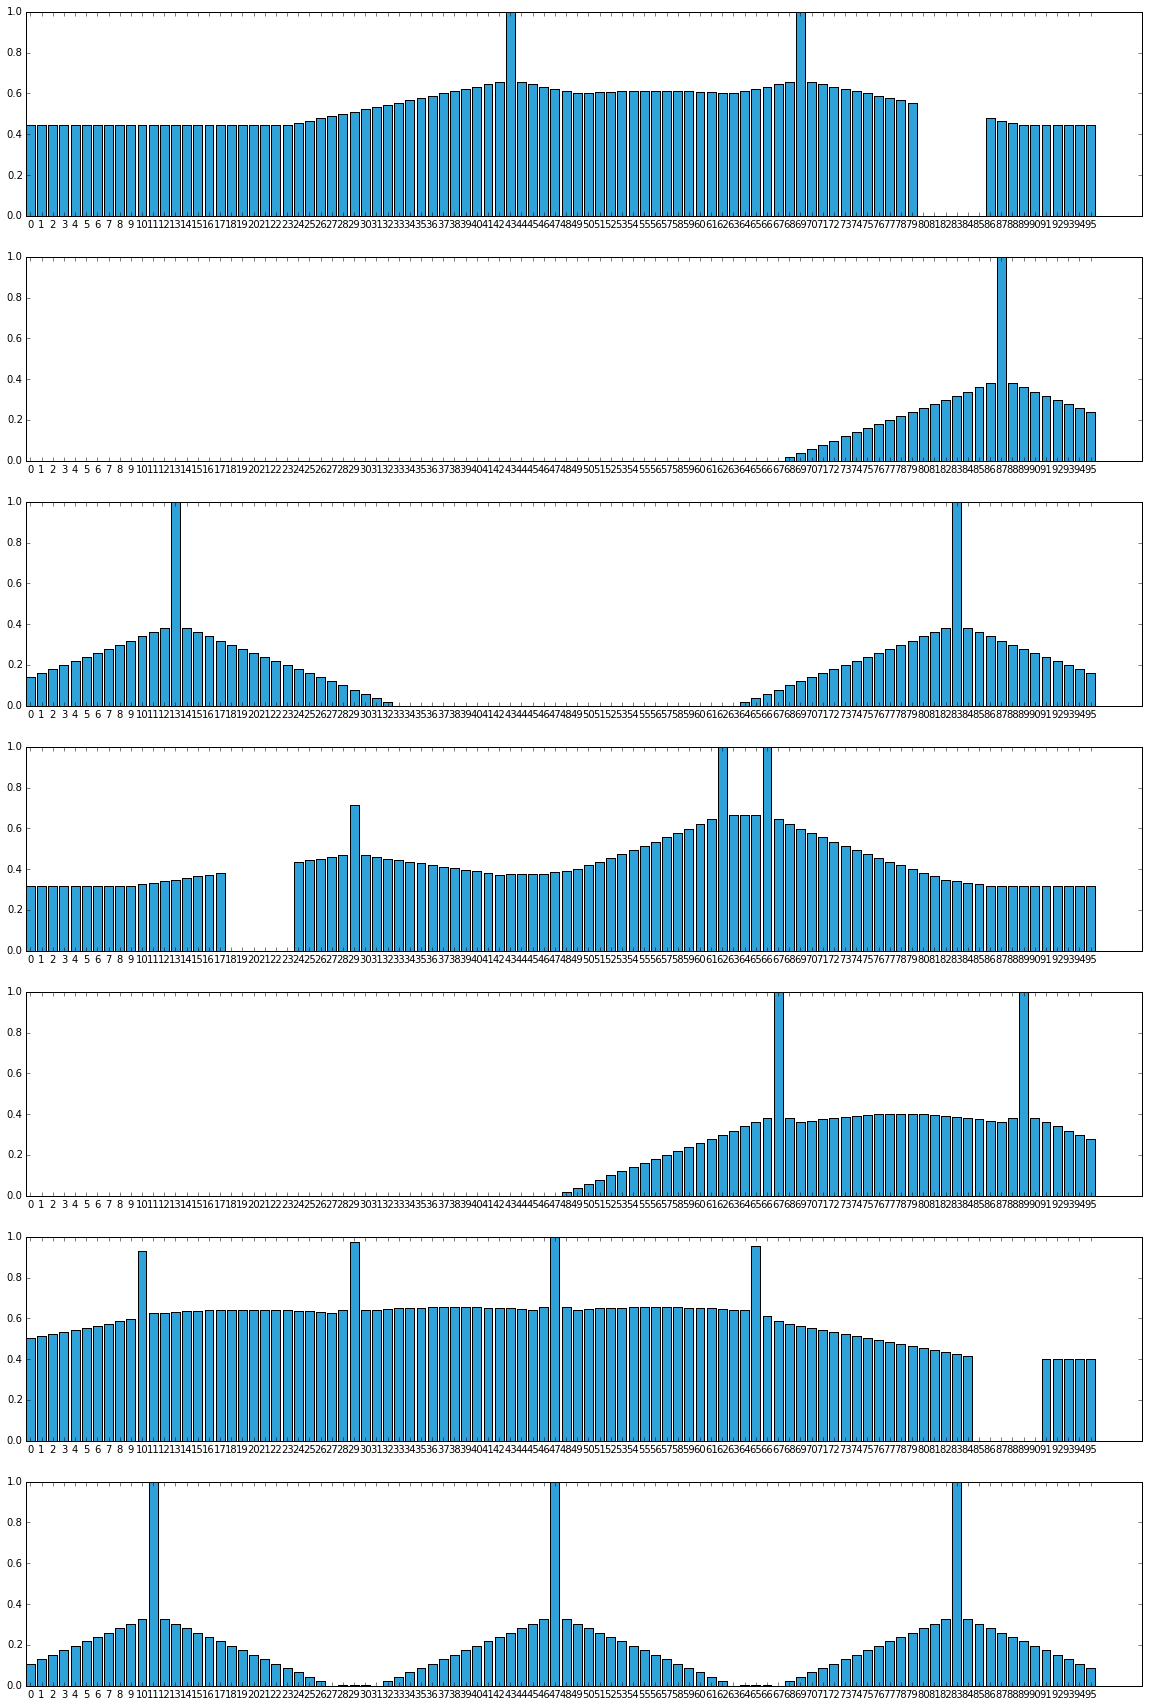

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
import book_plot as bp
plt.figure(figsize=(20,30),dpi=2540)
for i in range(len(p)):
#     p[i] = [(1-p[i][k]/max(p[i])) for k in range(len(p[i]))]
    plt.subplot(len(p),1,i+1)
    bp.bar_plot(p[i])
plt.show()

In [15]:
q=p

In [6]:
# Data thresholding
for i in range(len(q)):
    for j in range(len(q[i])):
        if q[i][j] > 0.2:
            q[i][j] = max(q[i])

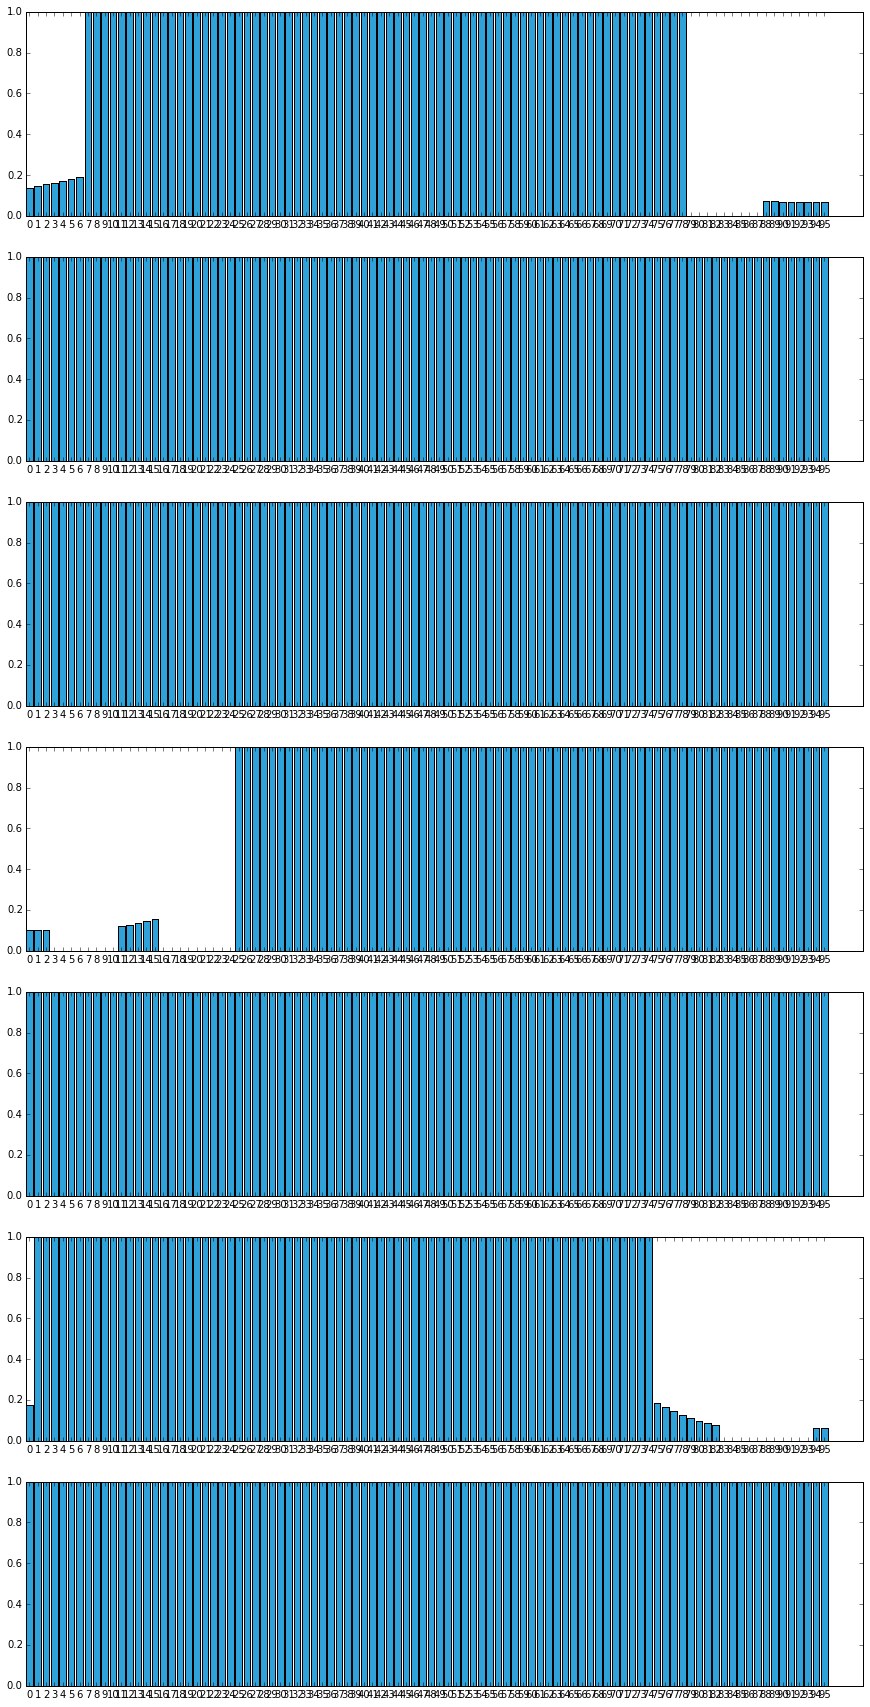

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import book_plot as bp
plt.figure(figsize=(15,30),dpi=2540)
for i in range(len(q)):
    plt.subplot(len(q),1,i+1)
    bp.bar_plot(q[i])
plt.show()

In [8]:
r=q

In [9]:
# Clubbing of landmarks
t = 0.75
length = 480
block = 5
size = int(100 / (block*2))
alength = int(length/block)
for i in range(len(r)):
    threshold = max(r[i])*t
    j = 0
    while j < len(r[i])-1:
        if r[i][j] == max(r[i]):
            j = j + 1
            continue
        if j < size:
            if max(r[i][0:size]) < threshold:
                j = size
                continue
            else:
                for l in range(size):
                    r[i][l] = max(r[i])
                j = size
                continue
                    
        elif j > alength-size:     
            if max(r[i][alength-size:alength-1]) < threshold:
                j = alength-1
                continue
            else:
                for l in range(size):
                    r[i][alength-1-l] = max(r[i])
                j = alength-1
                continue
    
        elif j>=size and j <=alength-size:
            condl, condr, k = -1, -1, 0
            while k < size and condl < 0:
                if r[i][j-k] > threshold:
                    condl = k
                    k = k + 1
                else:
                    k = k + 1
            k = 0
            while k < size  and condr < 0:
                if r[i][j+k] > threshold:
                    condr = k
                    k = k + 1
                else:
                    k = k + 1
            if condl != -1 and condr != -1:
                for k in range(size): # Corridor width threshold
                    if k < condl:
                        r[i][j-k]=max(r[i])
                    if k < condr:
                        r[i][j+k]=max(r[i])
                j = j + 1
                continue
            else:
                j = j + 1
                continue
            
        else:
            j = j + 1

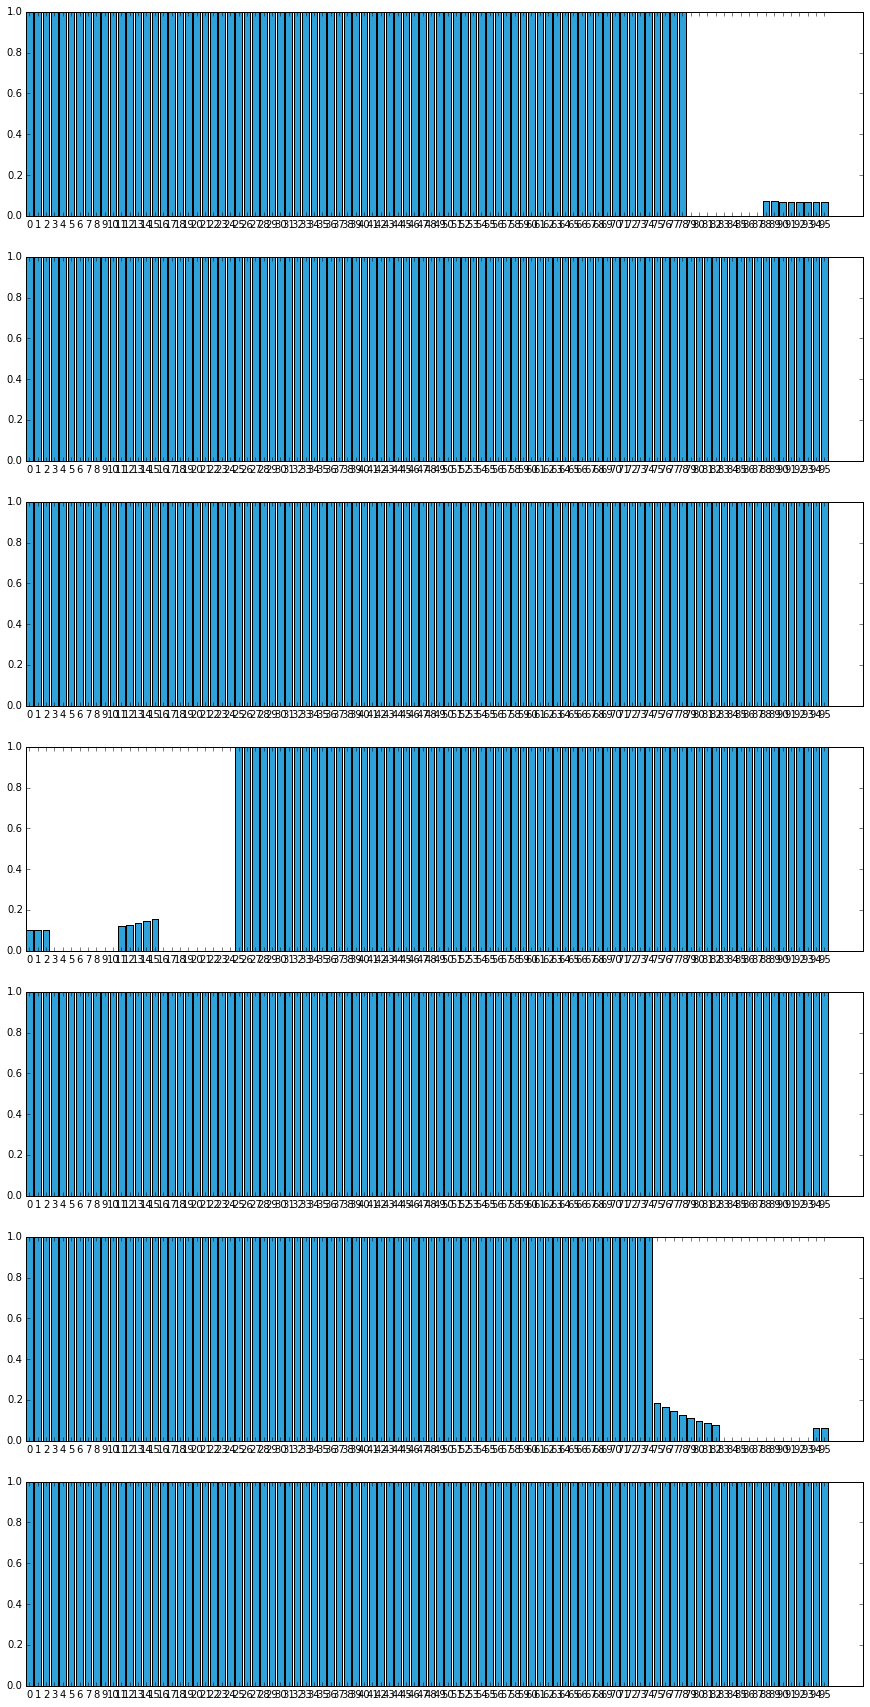

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
import book_plot as bp
plt.figure(figsize=(15,30),dpi=2540)
for i in range(len(r)):
    plt.subplot(len(r),1,i+1)
    bp.bar_plot(r[i])
plt.show()

In [11]:
a= [[]]
for i in range(len(r)):
    r[i] = [(1-r[i][k]/max(r[i])) for k in range(len(r[i]))]
    r[i] = list(reversed(r[i]))
    for j in range(len(r[i])):
        a[i].append([r[i][j]]*3)
    a.append([])

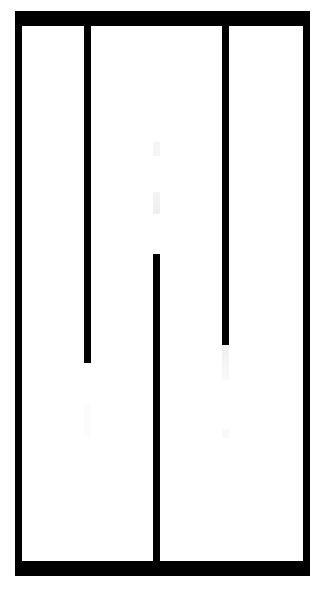

In [12]:
# Creating the wall
import matplotlib as mpl
import matplotlib.pyplot as pyplot
fig = pyplot.figure(figsize=(8,8),dpi=2540)

ax1 = fig.add_axes([0.22, 0.25, 0.0125, 0.74]) # GUI rectangle creation
ax1.set_axis_off()
cmap1 = mpl.colors.ListedColormap(a[0])
cmap2 = mpl.cm.Greys
norm = mpl.colors.Normalize()
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap1,
                                   norm=norm,
                                   orientation='vertical')
cb1.outline.set_visible(False)

ax1 = fig.add_axes([0.1, 0.0225, 0.0125, 0.9675]) # GUI rectangle creation
ax1.set_axis_off()
cmap1 = mpl.colors.ListedColormap(a[1])
cmap2 = mpl.cm.Greys
norm = mpl.colors.Normalize()
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap1,
                                   norm=norm,
                                   orientation='vertical')
cb1.outline.set_visible(False)

ax1 = fig.add_axes([0.1, 0.01, 0.5, 0.025]) # GUI rectangle creation
ax1.set_axis_off()
cmap1 = mpl.colors.ListedColormap(a[2])
cmap2 = mpl.cm.Greys
norm = mpl.colors.Normalize()
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap1,
                                   norm=norm,
                                   orientation='horizontal')
cb1.outline.set_visible(False)

ax1 = fig.add_axes([0.34, 0.0225, 0.0125, 0.74]) # GUI rectangle creation
ax1.set_axis_off()
cmap1 = mpl.colors.ListedColormap(a[3])
cmap2 = mpl.cm.Greys
norm = mpl.colors.Normalize()
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap1,
                                   norm=norm,
                                   orientation='vertical')
cb1.outline.set_visible(False)

ax1 = fig.add_axes([0.1, 0.965, 0.5, 0.025]) # GUI rectangle creation
ax1.set_axis_off()
cmap1 = mpl.colors.ListedColormap(a[4])
cmap2 = mpl.cm.Greys
norm = mpl.colors.Normalize()
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap1,
                                   norm=norm,
                                   orientation='horizontal')
cb1.outline.set_visible(False)

ax1 = fig.add_axes([0.46, 0.25, 0.0125, 0.74]) # GUI rectangle creation
ax1.set_axis_off()
cmap1 = mpl.colors.ListedColormap(a[5])
cmap2 = mpl.cm.Greys
norm = mpl.colors.Normalize()
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap1,
                                   norm=norm,
                                   orientation='vertical')
cb1.outline.set_visible(False)

ax1 = fig.add_axes([0.6, 0.01, 0.0125, 0.98]) # GUI rectangle creation
ax1.set_axis_off()
cmap1 = mpl.colors.ListedColormap(a[6])
cmap2 = mpl.cm.Greys
norm = mpl.colors.Normalize()
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap1,
                                   norm=norm,
                                   orientation='vertical')
cb1.outline.set_visible(False)


pyplot.show()